In [34]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, MaxPooling1D, Conv1D
from keras.layers import LSTM, Bidirectional, Dropout, Embedding, GRU, Bidirectional
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD  # note add tensorflow
from sklearn.metrics import roc_auc_score  # for evaluating classifier
import tensorflow as tf  # for tensorflow metrics
from tensorflow import keras
import keras_tuner as kt

In [35]:
# load data
file_path = './datafiles/blindPosts/'
files = [file_path + f for f in os.listdir(file_path)]
df = pd.concat([pd.read_csv(f, parse_dates=True).iloc[:, 1:]
                for f in files])
df = df.set_index('company')

# change data type
df = df.rename({'post_like': 'likes', 'post_comment': 'comments'}, axis=1)
df['post_firm'] = df['post_firm'].map(lambda x: str(x).replace('/company/', '').rstrip('/'))
df['likes'] = df['likes'].map(lambda x: str(x).replace(',', ''))
df['comments'] = df['comments'].map(lambda x: str(x).replace(',', ''))
df['likes'] = pd.to_numeric(df['likes'])
df['comments'] = pd.to_numeric(df['comments'])
df['post_timestamp'] = pd.to_datetime(df['post_timestamp'])
df = df.reset_index().set_index(
    ['company', 'post_timestamp']).sort_index().reset_index()

# let's generate labels popular and controversial based on likes and comments 
df[~df['post_text'].duplicated()]
df['popular'] = np.where(df['likes'] > df['likes'].quantile(0.99), 1, 0)
df['controversial'] = np.where(df['comments'] > df['comments'].quantile(0.99), 1, 0)
data = df[['post_text', 'post_firm', 'popular', 'controversial']] # keep poster company if available

In [37]:
# imbalanced data correction
# examine imbalance
neg, pos = np.bincount(df['popular'])
total = neg + pos
INITIAL_BIAS = np.log([pos/neg])
print("Positive rate:", round(pos/total*100,3), '%')
# class weights
# scaling by total/2 helps keep the loss to a similar magnitude.
# the sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Positive rate: 0.99 %
Weight for class 0: 0.51
Weight for class 1: 50.49


In [38]:
MAX_SEQUENCE_LENGTH = 400
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 2048  # make sure each batch has chance of obtaining positive examples
EPOCHS = 30
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

np.random.seed(7)


In [39]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./datafiles/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

# prepare text samples and their labels
print('Loading in comments')
train = data
sentences = train['post_text'].fillna('DUMMY_VALUE').values
possible_labels = ['controversial', 'popular']
targets = train[possible_labels].values  # N * 2 matrix

s = sorted(len(s) for s in sentences)
print("median sequence length: ", s[len(s)//2])
print("max sequence length: ", s[-1])
print("min sequence length: ", s[0])
# convert the sentences (strings) to ints
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print(sequences[0])
# get word -> int mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
# pad sequences so that we get N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)


Loading word vectors...
Found 400000 word vectors.
Loading in comments
median sequence length:  276
max sequence length:  24302
min sequence length:  1
Found 134858 unique tokens.
Shape of data tensor:  (241157, 400)


In [40]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False,  # keep the embeddings fixed
)

Filling pre-trained embeddings...


In [41]:
# define hypermodel
# must use gpu otherwise crash 
# 1. using model bulder function 
# 2. subclassing hypermodel class 
# hyperband method 
def model_builder(hp):
  input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = embedding_layer(input_)
  # tune the number of hidden units 
  hp_units = hp.Int('units', min_value = 8, max_value = 96, steps = 16)

  x = Bidirectional(LSTM(units = hp_units, return_sequences=True))(x)
  x = GlobalMaxPooling1D()(x)
  output = Dense(len(possible_labels), activation='sigmoid')(x) 

  model = Model(input_, output)
   # tune the learning rate 
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      loss = 'binary_crossentropy', optimizer = Adam(learning_rate = hp_learning_rate),
      metrics = METRICS, 
  )
  return model 

tuner = kt.Hyperband(model_builder, 
                     objective = 'val_loss', # or val_auc
                     max_epochs = 10,
                     factor = 3,
                     directory = 'hyper',
                     project_name = 'blind',
                     seed = 42) # tuning job

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(data, targets,
             epochs = EPOCHS, validation_split = VALIDATION_SPLIT,
             callbacks = [stop_early],
             batch_size = BATCH_SIZE,
             class_weight = CLASS_WEIGHT
)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
 




Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |256               |?                 
learning_rate     |0.01              |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |2                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2


In [18]:
print('Building model...')
# baseline logistic regression model 
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x) 
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate = 0.01), 
    metrics= METRICS # accuracy is not good for this task 
)


# set callbacks to prevent overfit and save as checkpts
checkpoint_path = './checkpoint/baseline_logit.cpkt'
checkpoint_dir = os.path.dirname(checkpoint_path)
CALL_BACKS = [
    # how many epochs without improvement you allow before the cb interferes
    EarlyStopping(monitor='val_loss', patience=20,
                  mode='min', min_delta=0.0001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss',
                    save_best_only=True, mode='min'
                    ),
]

print('Training model...')
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    class_weight = CLASS_WEIGHT,
    callbacks = [CALL_BACKS] # prevents overfit 
)

Building model...
Training model...
Epoch 1/30
95/95 [==============================] - 59s 495ms/step - loss: 0.2145 - tp: 363.0000 - fp: 9550.0000 - tn: 372561.0000 - fn: 3376.0000 - accuracy: 0.9665 - precision: 0.0366 - recall: 0.0971 - auc: 0.5336 - prc: 0.0183 - val_loss: 0.1616 - val_tp: 46.0000 - val_fp: 256.0000 - val_tn: 95149.0000 - val_fn: 1013.0000 - val_accuracy: 0.9868 - val_precision: 0.1523 - val_recall: 0.0434 - val_auc: 0.4925 - val_prc: 0.0251
Epoch 2/30
95/95 [==============================] - 38s 401ms/step - loss: 0.1770 - tp: 667.0000 - fp: 9758.0000 - tn: 372353.0000 - fn: 3072.0000 - accuracy: 0.9667 - precision: 0.0640 - recall: 0.1784 - auc: 0.5328 - prc: 0.0398 - val_loss: 0.1868 - val_tp: 193.0000 - val_fp: 2681.0000 - val_tn: 92724.0000 - val_fn: 866.0000 - val_accuracy: 0.9632 - val_precision: 0.0672 - val_recall: 0.1822 - val_auc: 0.5079 - val_prc: 0.0443
Epoch 3/30
95/95 [==============================] - 28s 299ms/step - loss: 0.1642 - tp: 847.0000 - 

In [159]:
# cnn model 
Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(32, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x= GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x) 
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate = 0.01), 
    metrics= METRICS # accuracy is not good for this task 
)


# set callbacks to prevent overfit and save as checkpts
checkpoint_path = './checkpoint/cnn.cpkt'
checkpoint_dir = os.path.dirname(checkpoint_path)
CALL_BACKS = [
    # how many epochs without improvement you allow before the cb interferes
    EarlyStopping(monitor='val_loss', patience=20,
                  mode='min', min_delta=0.0001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss',
                    save_best_only=True, mode='min'
                    ),
]

print('Training model...')
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    class_weight = CLASS_WEIGHT,
    callbacks = [CALL_BACKS] # prevents overfit 
)

Training model...
Epoch 1/30
95/95 [==============================] - ETA: 0s - loss: 0.1566 - tp: 873.0000 - fp: 10564.0000 - tn: 371547.0000 - fn: 2866.0000 - accuracy: 0.9652 - precision: 0.0763 - recall: 0.2335 - auc: 0.5771 - prc: 0.0871INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 267s 3s/step - loss: 0.1566 - tp: 873.0000 - fp: 10564.0000 - tn: 371547.0000 - fn: 2866.0000 - accuracy: 0.9652 - precision: 0.0763 - recall: 0.2335 - auc: 0.5771 - prc: 0.0871 - val_loss: 0.0888 - val_tp: 120.0000 - val_fp: 474.0000 - val_tn: 94931.0000 - val_fn: 939.0000 - val_accuracy: 0.9854 - val_precision: 0.2020 - val_recall: 0.1133 - val_auc: 0.5721 - val_prc: 0.0892
Epoch 2/30
95/95 [==============================] - 185s 2s/step - loss: 0.1123 - tp: 933.0000 - fp: 6463.0000 - tn: 375648.0000 - fn: 2806.0000 - accuracy: 0.9760 - precision: 0.1261 - recall: 0.2495 - auc: 0.6529 - prc: 0.1278 - val_loss: 0.1105 - val_tp: 287.0000 - val_fp: 1505.0000 - val_tn: 93900.0000 - val_fn: 772.0000 - val_accuracy: 0.9764 - val_precision: 0.1602 - val_recall: 0.2710 - val_auc: 0.6677 - val_prc: 0.1401
Epoch 3/30
95/95 [==============================] - 154s 2s/step - loss: 0.0904 - tp: 1162.0000 - fp: 5694.0000 - tn: 376417.0000 - fn: 2577.0000 - a

INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 154s 2s/step - loss: 0.0749 - tp: 1361.0000 - fp: 4536.0000 - tn: 377575.0000 - fn: 2378.0000 - accuracy: 0.9821 - precision: 0.2308 - recall: 0.3640 - auc: 0.7393 - prc: 0.2541 - val_loss: 0.0881 - val_tp: 339.0000 - val_fp: 1297.0000 - val_tn: 94108.0000 - val_fn: 720.0000 - val_accuracy: 0.9791 - val_precision: 0.2072 - val_recall: 0.3201 - val_auc: 0.7192 - val_prc: 0.2353
Epoch 5/30
95/95 [==============================] - ETA: 0s - loss: 0.0650 - tp: 1466.0000 - fp: 4103.0000 - tn: 378008.0000 - fn: 2273.0000 - accuracy: 0.9835 - precision: 0.2632 - recall: 0.3921 - auc: 0.7640 - prc: 0.3077INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 167s 2s/step - loss: 0.0650 - tp: 1466.0000 - fp: 4103.0000 - tn: 378008.0000 - fn: 2273.0000 - accuracy: 0.9835 - precision: 0.2632 - recall: 0.3921 - auc: 0.7640 - prc: 0.3077 - val_loss: 0.0814 - val_tp: 290.0000 - val_fp: 772.0000 - val_tn: 94633.0000 - val_fn: 769.0000 - val_accuracy: 0.9840 - val_precision: 0.2731 - val_recall: 0.2738 - val_auc: 0.6553 - val_prc: 0.1970
Epoch 6/30
95/95 [==============================] - ETA: 0s - loss: 0.0699 - tp: 1455.0000 - fp: 4450.0000 - tn: 377661.0000 - fn: 2284.0000 - accuracy: 0.9825 - precision: 0.2464 - recall: 0.3891 - auc: 0.7392 - prc: 0.2806INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 162s 2s/step - loss: 0.0699 - tp: 1455.0000 - fp: 4450.0000 - tn: 377661.0000 - fn: 2284.0000 - accuracy: 0.9825 - precision: 0.2464 - recall: 0.3891 - auc: 0.7392 - prc: 0.2806 - val_loss: 0.0656 - val_tp: 286.0000 - val_fp: 341.0000 - val_tn: 95064.0000 - val_fn: 773.0000 - val_accuracy: 0.9885 - val_precision: 0.4561 - val_recall: 0.2701 - val_auc: 0.6888 - val_prc: 0.2617
Epoch 7/30
95/95 [==============================] - 161s 2s/step - loss: 0.0551 - tp: 1517.0000 - fp: 3149.0000 - tn: 378962.0000 - fn: 2222.0000 - accuracy: 0.9861 - precision: 0.3251 - recall: 0.4057 - auc: 0.7734 - prc: 0.3440 - val_loss: 0.0750 - val_tp: 350.0000 - val_fp: 1087.0000 - val_tn: 94318.0000 - val_fn: 709.0000 - val_accuracy: 0.9814 - val_precision: 0.2436 - val_recall: 0.3305 - val_auc: 0.7534 - val_prc: 0.2615
Epoch 8/30
95/95 [==============================] - 276s 3s/step - loss: 0.0528 - tp: 1485.0000 - fp: 2986.0000 - tn: 379125.0000 - fn: 2254.0000 - 

INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 353s 4s/step - loss: 0.0462 - tp: 1505.0000 - fp: 2159.0000 - tn: 379952.0000 - fn: 2234.0000 - accuracy: 0.9886 - precision: 0.4108 - recall: 0.4025 - auc: 0.7916 - prc: 0.3749 - val_loss: 0.0645 - val_tp: 349.0000 - val_fp: 663.0000 - val_tn: 94742.0000 - val_fn: 710.0000 - val_accuracy: 0.9858 - val_precision: 0.3449 - val_recall: 0.3296 - val_auc: 0.7619 - val_prc: 0.3061
Epoch 10/30
95/95 [==============================] - 316s 3s/step - loss: 0.0430 - tp: 1561.0000 - fp: 2100.0000 - tn: 380011.0000 - fn: 2178.0000 - accuracy: 0.9889 - precision: 0.4264 - recall: 0.4175 - auc: 0.8052 - prc: 0.3968 - val_loss: 0.0764 - val_tp: 361.0000 - val_fp: 1010.0000 - val_tn: 94395.0000 - val_fn: 698.0000 - val_accuracy: 0.9823 - val_precision: 0.2633 - val_recall: 0.3409 - val_auc: 0.7490 - val_prc: 0.2716
Epoch 11/30
95/95 [==============================] - 288s 3s/step - loss: 0.0397 - tp: 1615.0000 - fp: 1707.0000 - tn: 380404.0000 - fn: 2124.0000 

INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 346s 4s/step - loss: 0.0358 - tp: 1806.0000 - fp: 1239.0000 - tn: 380872.0000 - fn: 1933.0000 - accuracy: 0.9918 - precision: 0.5931 - recall: 0.4830 - auc: 0.8283 - prc: 0.4843 - val_loss: 0.0521 - val_tp: 355.0000 - val_fp: 235.0000 - val_tn: 95170.0000 - val_fn: 704.0000 - val_accuracy: 0.9903 - val_precision: 0.6017 - val_recall: 0.3352 - val_auc: 0.7637 - val_prc: 0.3641
Epoch 16/30
95/95 [==============================] - 229s 2s/step - loss: 0.0305 - tp: 1811.0000 - fp: 613.0000 - tn: 381498.0000 - fn: 1928.0000 - accuracy: 0.9934 - precision: 0.7471 - recall: 0.4844 - auc: 0.8414 - prc: 0.5206 - val_loss: 0.0536 - val_tp: 393.0000 - val_fp: 288.0000 - val_tn: 95117.0000 - val_fn: 666.0000 - val_accuracy: 0.9901 - val_precision: 0.5771 - val_recall: 0.3711 - val_auc: 0.7608 - val_prc: 0.3748
Epoch 17/30
95/95 [==============================] - 221s 2s/step - loss: 0.0297 - tp: 1897.0000 - fp: 598.0000 - tn: 381513.0000 - fn: 1842.0000 - a

INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 231s 2s/step - loss: 0.0281 - tp: 1909.0000 - fp: 396.0000 - tn: 381715.0000 - fn: 1830.0000 - accuracy: 0.9942 - precision: 0.8282 - recall: 0.5106 - auc: 0.8561 - prc: 0.5633 - val_loss: 0.0503 - val_tp: 384.0000 - val_fp: 90.0000 - val_tn: 95315.0000 - val_fn: 675.0000 - val_accuracy: 0.9921 - val_precision: 0.8101 - val_recall: 0.3626 - val_auc: 0.7540 - val_prc: 0.4070
Epoch 19/30
95/95 [==============================] - ETA: 0s - loss: 0.0262 - tp: 2015.0000 - fp: 276.0000 - tn: 381835.0000 - fn: 1724.0000 - accuracy: 0.9948 - precision: 0.8795 - recall: 0.5389 - auc: 0.8658 - prc: 0.6094INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 239s 2s/step - loss: 0.0262 - tp: 2015.0000 - fp: 276.0000 - tn: 381835.0000 - fn: 1724.0000 - accuracy: 0.9948 - precision: 0.8795 - recall: 0.5389 - auc: 0.8658 - prc: 0.6094 - val_loss: 0.0483 - val_tp: 408.0000 - val_fp: 114.0000 - val_tn: 95291.0000 - val_fn: 651.0000 - val_accuracy: 0.9921 - val_precision: 0.7816 - val_recall: 0.3853 - val_auc: 0.7747 - val_prc: 0.4250
Epoch 20/30
95/95 [==============================] - ETA: 0s - loss: 0.0248 - tp: 2116.0000 - fp: 140.0000 - tn: 381971.0000 - fn: 1623.0000 - accuracy: 0.9954 - precision: 0.9379 - recall: 0.5659 - auc: 0.8824 - prc: 0.6438INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 251s 3s/step - loss: 0.0248 - tp: 2116.0000 - fp: 140.0000 - tn: 381971.0000 - fn: 1623.0000 - accuracy: 0.9954 - precision: 0.9379 - recall: 0.5659 - auc: 0.8824 - prc: 0.6438 - val_loss: 0.0478 - val_tp: 424.0000 - val_fp: 51.0000 - val_tn: 95354.0000 - val_fn: 635.0000 - val_accuracy: 0.9929 - val_precision: 0.8926 - val_recall: 0.4004 - val_auc: 0.7683 - val_prc: 0.4525
Epoch 21/30
95/95 [==============================] - ETA: 0s - loss: 0.0238 - tp: 2213.0000 - fp: 94.0000 - tn: 382017.0000 - fn: 1526.0000 - accuracy: 0.9958 - precision: 0.9593 - recall: 0.5919 - auc: 0.8902 - prc: 0.6703INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 246s 3s/step - loss: 0.0238 - tp: 2213.0000 - fp: 94.0000 - tn: 382017.0000 - fn: 1526.0000 - accuracy: 0.9958 - precision: 0.9593 - recall: 0.5919 - auc: 0.8902 - prc: 0.6703 - val_loss: 0.0440 - val_tp: 440.0000 - val_fp: 79.0000 - val_tn: 95326.0000 - val_fn: 619.0000 - val_accuracy: 0.9928 - val_precision: 0.8478 - val_recall: 0.4155 - val_auc: 0.7839 - val_prc: 0.4718
Epoch 22/30
95/95 [==============================] - 246s 3s/step - loss: 0.0232 - tp: 2332.0000 - fp: 67.0000 - tn: 382044.0000 - fn: 1407.0000 - accuracy: 0.9962 - precision: 0.9721 - recall: 0.6237 - auc: 0.8986 - prc: 0.6968 - val_loss: 0.0445 - val_tp: 456.0000 - val_fp: 78.0000 - val_tn: 95327.0000 - val_fn: 603.0000 - val_accuracy: 0.9929 - val_precision: 0.8539 - val_recall: 0.4306 - val_auc: 0.7831 - val_prc: 0.4883
Epoch 23/30
95/95 [==============================] - ETA: 0s - loss: 0.0222 - tp: 2398.0000 - fp: 74.0000 - tn: 382037.0000 - fn: 1341.0000 - accuracy: 0.

INFO:tensorflow:Assets written to: ./checkpoint/cnn.cpkt/assets


95/95 [==============================] - 179s 2s/step - loss: 0.0222 - tp: 2398.0000 - fp: 74.0000 - tn: 382037.0000 - fn: 1341.0000 - accuracy: 0.9963 - precision: 0.9701 - recall: 0.6413 - auc: 0.9056 - prc: 0.7216 - val_loss: 0.0438 - val_tp: 475.0000 - val_fp: 87.0000 - val_tn: 95318.0000 - val_fn: 584.0000 - val_accuracy: 0.9930 - val_precision: 0.8452 - val_recall: 0.4485 - val_auc: 0.7807 - val_prc: 0.4965
Epoch 24/30
95/95 [==============================] - 210s 2s/step - loss: 0.0217 - tp: 2485.0000 - fp: 59.0000 - tn: 382052.0000 - fn: 1254.0000 - accuracy: 0.9966 - precision: 0.9768 - recall: 0.6646 - auc: 0.9170 - prc: 0.7419 - val_loss: 0.0462 - val_tp: 488.0000 - val_fp: 62.0000 - val_tn: 95343.0000 - val_fn: 571.0000 - val_accuracy: 0.9934 - val_precision: 0.8873 - val_recall: 0.4608 - val_auc: 0.7805 - val_prc: 0.5074
Epoch 25/30
95/95 [==============================] - 172s 2s/step - loss: 0.0213 - tp: 2540.0000 - fp: 61.0000 - tn: 382050.0000 - fn: 1199.0000 - accurac

In [137]:
# compile and train lstm model 
# change model to bidirectional rnn (simple change)
print('Building model...')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x) # could change RNN model
x = GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x) 

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics= METRICS # accuracy is not good for this task 
)


# set callbacks to prevent overfit and save as checkpts
checkpoint_path = './checkpoint/cp.cpkt'
checkpoint_dir = os.path.dirname(checkpoint_path)
CALL_BACKS = [
    # how many epochs without improvement you allow before the cb interferes
    EarlyStopping(monitor='val_loss', patience=5,
                  mode='min', min_delta=0.0001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss',
                    save_best_only=True, mode='min'
                    ),
]

print('Training model...')
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    class_weight = CLASS_WEIGHT,
    callbacks = [CALL_BACKS] # prevents overfit 
)

Training model...
Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 0.1810 - tp: 550.0000 - fp: 8988.0000 - tn: 373123.0000 - fn: 3189.0000 - accuracy: 0.9684 - precision: 0.0577 - recall: 0.1471 - auc: 0.5742 - prc: 0.0387

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 309s 3s/step - loss: 0.1810 - tp: 550.0000 - fp: 8988.0000 - tn: 373123.0000 - fn: 3189.0000 - accuracy: 0.9684 - precision: 0.0577 - recall: 0.1471 - auc: 0.5742 - prc: 0.0387 - val_loss: 0.1813 - val_tp: 315.0000 - val_fp: 4729.0000 - val_tn: 90676.0000 - val_fn: 744.0000 - val_accuracy: 0.9433 - val_precision: 0.0625 - val_recall: 0.2975 - val_auc: 0.5696 - val_prc: 0.0708
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.1173 - tp: 1097.0000 - fp: 9942.0000 - tn: 372169.0000 - fn: 2642.0000 - accuracy: 0.9674 - precision: 0.0994 - recall: 0.2934 - auc: 0.5882 - prc: 0.0730

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 359s 4s/step - loss: 0.1173 - tp: 1097.0000 - fp: 9942.0000 - tn: 372169.0000 - fn: 2642.0000 - accuracy: 0.9674 - precision: 0.0994 - recall: 0.2934 - auc: 0.5882 - prc: 0.0730 - val_loss: 0.1167 - val_tp: 264.0000 - val_fp: 2308.0000 - val_tn: 93097.0000 - val_fn: 795.0000 - val_accuracy: 0.9678 - val_precision: 0.1026 - val_recall: 0.2493 - val_auc: 0.5705 - val_prc: 0.0774
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 0.0982 - tp: 1151.0000 - fp: 8417.0000 - tn: 373694.0000 - fn: 2588.0000 - accuracy: 0.9715 - precision: 0.1203 - recall: 0.3078 - auc: 0.6087 - prc: 0.0930

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 365s 4s/step - loss: 0.0982 - tp: 1151.0000 - fp: 8417.0000 - tn: 373694.0000 - fn: 2588.0000 - accuracy: 0.9715 - precision: 0.1203 - recall: 0.3078 - auc: 0.6087 - prc: 0.0930 - val_loss: 0.0944 - val_tp: 232.0000 - val_fp: 1435.0000 - val_tn: 93970.0000 - val_fn: 827.0000 - val_accuracy: 0.9766 - val_precision: 0.1392 - val_recall: 0.2191 - val_auc: 0.5695 - val_prc: 0.0824
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 0.0855 - tp: 1164.0000 - fp: 6999.0000 - tn: 375112.0000 - fn: 2575.0000 - accuracy: 0.9752 - precision: 0.1426 - recall: 0.3113 - auc: 0.6144 - prc: 0.1110

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 287s 3s/step - loss: 0.0855 - tp: 1164.0000 - fp: 6999.0000 - tn: 375112.0000 - fn: 2575.0000 - accuracy: 0.9752 - precision: 0.1426 - recall: 0.3113 - auc: 0.6144 - prc: 0.1110 - val_loss: 0.0837 - val_tp: 216.0000 - val_fp: 1144.0000 - val_tn: 94261.0000 - val_fn: 843.0000 - val_accuracy: 0.9794 - val_precision: 0.1588 - val_recall: 0.2040 - val_auc: 0.5828 - val_prc: 0.0911
Epoch 5/50
95/95 [==============================] - 222s 2s/step - loss: 0.0783 - tp: 1217.0000 - fp: 6995.0000 - tn: 375116.0000 - fn: 2522.0000 - accuracy: 0.9753 - precision: 0.1482 - recall: 0.3255 - auc: 0.6497 - prc: 0.1240 - val_loss: 0.0925 - val_tp: 291.0000 - val_fp: 1624.0000 - val_tn: 93781.0000 - val_fn: 768.0000 - val_accuracy: 0.9752 - val_precision: 0.1520 - val_recall: 0.2748 - val_auc: 0.6297 - val_prc: 0.1094
Epoch 6/50
95/95 [==============================] - ETA: 0s - loss: 0.0708 - tp: 1216.0000 - fp: 6121.0000 - tn: 375990.0000 - fn: 2523.0000 - accu

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 205s 2s/step - loss: 0.0708 - tp: 1216.0000 - fp: 6121.0000 - tn: 375990.0000 - fn: 2523.0000 - accuracy: 0.9776 - precision: 0.1657 - recall: 0.3252 - auc: 0.7066 - prc: 0.1439 - val_loss: 0.0789 - val_tp: 249.0000 - val_fp: 1118.0000 - val_tn: 94287.0000 - val_fn: 810.0000 - val_accuracy: 0.9800 - val_precision: 0.1822 - val_recall: 0.2351 - val_auc: 0.6693 - val_prc: 0.1160
Epoch 7/50
95/95 [==============================] - ETA: 0s - loss: 0.0664 - tp: 1231.0000 - fp: 6063.0000 - tn: 376048.0000 - fn: 2508.0000 - accuracy: 0.9778 - precision: 0.1688 - recall: 0.3292 - auc: 0.7409 - prc: 0.1651

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 222s 2s/step - loss: 0.0664 - tp: 1231.0000 - fp: 6063.0000 - tn: 376048.0000 - fn: 2508.0000 - accuracy: 0.9778 - precision: 0.1688 - recall: 0.3292 - auc: 0.7409 - prc: 0.1651 - val_loss: 0.0773 - val_tp: 257.0000 - val_fp: 1213.0000 - val_tn: 94192.0000 - val_fn: 802.0000 - val_accuracy: 0.9791 - val_precision: 0.1748 - val_recall: 0.2427 - val_auc: 0.7127 - val_prc: 0.1334
Epoch 8/50
95/95 [==============================] - 217s 2s/step - loss: 0.0589 - tp: 1271.0000 - fp: 5098.0000 - tn: 377013.0000 - fn: 2468.0000 - accuracy: 0.9804 - precision: 0.1996 - recall: 0.3399 - auc: 0.7759 - prc: 0.1886 - val_loss: 0.0848 - val_tp: 295.0000 - val_fp: 1586.0000 - val_tn: 93819.0000 - val_fn: 764.0000 - val_accuracy: 0.9756 - val_precision: 0.1568 - val_recall: 0.2786 - val_auc: 0.7137 - val_prc: 0.1556
Epoch 9/50
95/95 [==============================] - ETA: 0s - loss: 0.0581 - tp: 1250.0000 - fp: 5241.0000 - tn: 376870.0000 - fn: 2489.0000 - accu

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 204s 2s/step - loss: 0.0581 - tp: 1250.0000 - fp: 5241.0000 - tn: 376870.0000 - fn: 2489.0000 - accuracy: 0.9800 - precision: 0.1926 - recall: 0.3343 - auc: 0.7642 - prc: 0.1951 - val_loss: 0.0750 - val_tp: 262.0000 - val_fp: 1086.0000 - val_tn: 94319.0000 - val_fn: 797.0000 - val_accuracy: 0.9805 - val_precision: 0.1944 - val_recall: 0.2474 - val_auc: 0.7133 - val_prc: 0.1551
Epoch 10/50
95/95 [==============================] - 216s 2s/step - loss: 0.0523 - tp: 1255.0000 - fp: 4535.0000 - tn: 377576.0000 - fn: 2484.0000 - accuracy: 0.9818 - precision: 0.2168 - recall: 0.3357 - auc: 0.7883 - prc: 0.2222 - val_loss: 0.0905 - val_tp: 290.0000 - val_fp: 1808.0000 - val_tn: 93597.0000 - val_fn: 769.0000 - val_accuracy: 0.9733 - val_precision: 0.1382 - val_recall: 0.2738 - val_auc: 0.7235 - val_prc: 0.1561
Epoch 11/50
95/95 [==============================] - ETA: 0s - loss: 0.0513 - tp: 1226.0000 - fp: 4522.0000 - tn: 377589.0000 - fn: 2513.0000 - ac

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 292s 3s/step - loss: 0.0513 - tp: 1226.0000 - fp: 4522.0000 - tn: 377589.0000 - fn: 2513.0000 - accuracy: 0.9818 - precision: 0.2133 - recall: 0.3279 - auc: 0.7826 - prc: 0.2261 - val_loss: 0.0655 - val_tp: 244.0000 - val_fp: 825.0000 - val_tn: 94580.0000 - val_fn: 815.0000 - val_accuracy: 0.9830 - val_precision: 0.2283 - val_recall: 0.2304 - val_auc: 0.7492 - val_prc: 0.1625
Epoch 12/50
95/95 [==============================] - 314s 3s/step - loss: 0.0455 - tp: 1288.0000 - fp: 3709.0000 - tn: 378402.0000 - fn: 2451.0000 - accuracy: 0.9840 - precision: 0.2578 - recall: 0.3445 - auc: 0.7989 - prc: 0.2434 - val_loss: 0.0678 - val_tp: 262.0000 - val_fp: 844.0000 - val_tn: 94561.0000 - val_fn: 797.0000 - val_accuracy: 0.9830 - val_precision: 0.2369 - val_recall: 0.2474 - val_auc: 0.7313 - val_prc: 0.1706
Epoch 13/50
95/95 [==============================] - 285s 3s/step - loss: 0.0480 - tp: 1281.0000 - fp: 4005.0000 - tn: 378106.0000 - fn: 2458.0000 -

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 322s 3s/step - loss: 0.0394 - tp: 1282.0000 - fp: 2915.0000 - tn: 379196.0000 - fn: 2457.0000 - accuracy: 0.9861 - precision: 0.3055 - recall: 0.3429 - auc: 0.8050 - prc: 0.2689 - val_loss: 0.0578 - val_tp: 237.0000 - val_fp: 499.0000 - val_tn: 94906.0000 - val_fn: 822.0000 - val_accuracy: 0.9863 - val_precision: 0.3220 - val_recall: 0.2238 - val_auc: 0.7564 - val_prc: 0.1976
Epoch 15/50
95/95 [==============================] - 291s 3s/step - loss: 0.0355 - tp: 1280.0000 - fp: 2429.0000 - tn: 379682.0000 - fn: 2459.0000 - accuracy: 0.9873 - precision: 0.3451 - recall: 0.3423 - auc: 0.8185 - prc: 0.2994 - val_loss: 0.0595 - val_tp: 247.0000 - val_fp: 538.0000 - val_tn: 94867.0000 - val_fn: 812.0000 - val_accuracy: 0.9860 - val_precision: 0.3146 - val_recall: 0.2332 - val_auc: 0.7530 - val_prc: 0.2042
Epoch 16/50
95/95 [==============================] - ETA: 0s - loss: 0.0333 - tp: 1315.0000 - fp: 2167.0000 - tn: 379944.0000 - fn: 2424.0000 - accu

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 416s 4s/step - loss: 0.0333 - tp: 1315.0000 - fp: 2167.0000 - tn: 379944.0000 - fn: 2424.0000 - accuracy: 0.9881 - precision: 0.3777 - recall: 0.3517 - auc: 0.8185 - prc: 0.3166 - val_loss: 0.0566 - val_tp: 245.0000 - val_fp: 473.0000 - val_tn: 94932.0000 - val_fn: 814.0000 - val_accuracy: 0.9867 - val_precision: 0.3412 - val_recall: 0.2314 - val_auc: 0.7674 - val_prc: 0.2124
Epoch 17/50
95/95 [==============================] - 388s 4s/step - loss: 0.0307 - tp: 1334.0000 - fp: 1802.0000 - tn: 380309.0000 - fn: 2405.0000 - accuracy: 0.9891 - precision: 0.4254 - recall: 0.3568 - auc: 0.8282 - prc: 0.3412 - val_loss: 0.0587 - val_tp: 262.0000 - val_fp: 560.0000 - val_tn: 94845.0000 - val_fn: 797.0000 - val_accuracy: 0.9859 - val_precision: 0.3187 - val_recall: 0.2474 - val_auc: 0.7656 - val_prc: 0.2166
Epoch 18/50
95/95 [==============================] - ETA: 0s - loss: 0.0295 - tp: 1380.0000 - fp: 1739.0000 - tn: 380372.0000 - fn: 2359.0000 - accu

INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/cp.cpkt/assets


95/95 [==============================] - 341s 4s/step - loss: 0.0295 - tp: 1380.0000 - fp: 1739.0000 - tn: 380372.0000 - fn: 2359.0000 - accuracy: 0.9894 - precision: 0.4424 - recall: 0.3691 - auc: 0.8295 - prc: 0.3516 - val_loss: 0.0552 - val_tp: 239.0000 - val_fp: 385.0000 - val_tn: 95020.0000 - val_fn: 820.0000 - val_accuracy: 0.9875 - val_precision: 0.3830 - val_recall: 0.2257 - val_auc: 0.7596 - val_prc: 0.2320
Epoch 19/50
95/95 [==============================] - 312s 3s/step - loss: 0.0283 - tp: 1359.0000 - fp: 1560.0000 - tn: 380551.0000 - fn: 2380.0000 - accuracy: 0.9898 - precision: 0.4656 - recall: 0.3635 - auc: 0.8314 - prc: 0.3645 - val_loss: 0.0744 - val_tp: 322.0000 - val_fp: 1164.0000 - val_tn: 94241.0000 - val_fn: 737.0000 - val_accuracy: 0.9803 - val_precision: 0.2167 - val_recall: 0.3041 - val_auc: 0.7583 - val_prc: 0.1947
Epoch 20/50
95/95 [==============================] - 353s 4s/step - loss: 0.0313 - tp: 1367.0000 - fp: 2216.0000 - tn: 379895.0000 - fn: 2372.0000 

In [176]:
# change model to bidirectional rnn (simple change)
print('Building model...')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(15, return_sequences=True))(x) # could change RNN model
x = GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x) 

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate = 0.01), 
    metrics= METRICS # accuracy is not good for this task 
)


# set callbacks to prevent overfit and save as checkpts
checkpoint_path = './checkpoint/bidirectional.cpkt'
checkpoint_dir = os.path.dirname(checkpoint_path)
CALL_BACKS = [
    # how many epochs without improvement you allow before the cb interferes
    EarlyStopping(monitor='val_loss', patience=20,
                  mode='min', min_delta=0.0001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss',
                    save_best_only=True, mode='min'
                    ),
]

print('Training model...')
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    class_weight = CLASS_WEIGHT,
    callbacks = [CALL_BACKS] # prevents overfit 
)

Building model...
Training model...
Epoch 1/30
95/95 [==============================] - ETA: 0s - loss: 0.1605 - tp: 608.0000 - fp: 4647.0000 - tn: 377464.0000 - fn: 3131.0000 - accuracy: 0.9798 - precision: 0.1157 - recall: 0.1626 - auc: 0.5903 - prc: 0.0571

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 763s 8s/step - loss: 0.1605 - tp: 608.0000 - fp: 4647.0000 - tn: 377464.0000 - fn: 3131.0000 - accuracy: 0.9798 - precision: 0.1157 - recall: 0.1626 - auc: 0.5903 - prc: 0.0571 - val_loss: 0.1135 - val_tp: 247.0000 - val_fp: 1662.0000 - val_tn: 93743.0000 - val_fn: 812.0000 - val_accuracy: 0.9744 - val_precision: 0.1294 - val_recall: 0.2332 - val_auc: 0.5824 - val_prc: 0.0833
Epoch 2/30
95/95 [==============================] - ETA: 0s - loss: 0.0935 - tp: 1101.0000 - fp: 7964.0000 - tn: 374147.0000 - fn: 2638.0000 - accuracy: 0.9725 - precision: 0.1215 - recall: 0.2945 - auc: 0.6374 - prc: 0.1079

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 587s 6s/step - loss: 0.0935 - tp: 1101.0000 - fp: 7964.0000 - tn: 374147.0000 - fn: 2638.0000 - accuracy: 0.9725 - precision: 0.1215 - recall: 0.2945 - auc: 0.6374 - prc: 0.1079 - val_loss: 0.0772 - val_tp: 210.0000 - val_fp: 852.0000 - val_tn: 94553.0000 - val_fn: 849.0000 - val_accuracy: 0.9824 - val_precision: 0.1977 - val_recall: 0.1983 - val_auc: 0.6331 - val_prc: 0.1101
Epoch 3/30
95/95 [==============================] - ETA: 0s - loss: 0.0758 - tp: 1129.0000 - fp: 6671.0000 - tn: 375440.0000 - fn: 2610.0000 - accuracy: 0.9759 - precision: 0.1447 - recall: 0.3020 - auc: 0.6845 - prc: 0.1486

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 421s 4s/step - loss: 0.0758 - tp: 1129.0000 - fp: 6671.0000 - tn: 375440.0000 - fn: 2610.0000 - accuracy: 0.9759 - precision: 0.1447 - recall: 0.3020 - auc: 0.6845 - prc: 0.1486 - val_loss: 0.0705 - val_tp: 217.0000 - val_fp: 860.0000 - val_tn: 94545.0000 - val_fn: 842.0000 - val_accuracy: 0.9824 - val_precision: 0.2015 - val_recall: 0.2049 - val_auc: 0.7202 - val_prc: 0.1129
Epoch 4/30
95/95 [==============================] - 389s 4s/step - loss: 0.0624 - tp: 1164.0000 - fp: 5673.0000 - tn: 376438.0000 - fn: 2575.0000 - accuracy: 0.9786 - precision: 0.1703 - recall: 0.3113 - auc: 0.7414 - prc: 0.1683 - val_loss: 0.0774 - val_tp: 266.0000 - val_fp: 1228.0000 - val_tn: 94177.0000 - val_fn: 793.0000 - val_accuracy: 0.9790 - val_precision: 0.1780 - val_recall: 0.2512 - val_auc: 0.7050 - val_prc: 0.1385
Epoch 5/30
95/95 [==============================] - 354s 4s/step - loss: 0.0515 - tp: 1142.0000 - fp: 4448.0000 - tn: 377663.0000 - fn: 2597.0000 - 

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 370s 4s/step - loss: 0.0449 - tp: 1143.0000 - fp: 4227.0000 - tn: 377884.0000 - fn: 2596.0000 - accuracy: 0.9823 - precision: 0.2128 - recall: 0.3057 - auc: 0.7934 - prc: 0.2181 - val_loss: 0.0689 - val_tp: 274.0000 - val_fp: 928.0000 - val_tn: 94477.0000 - val_fn: 785.0000 - val_accuracy: 0.9822 - val_precision: 0.2280 - val_recall: 0.2587 - val_auc: 0.7599 - val_prc: 0.1843
Epoch 9/30
95/95 [==============================] - ETA: 0s - loss: 0.0338 - tp: 1239.0000 - fp: 2351.0000 - tn: 379760.0000 - fn: 2500.0000 - accuracy: 0.9874 - precision: 0.3451 - recall: 0.3314 - auc: 0.8200 - prc: 0.2762

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 398s 4s/step - loss: 0.0338 - tp: 1239.0000 - fp: 2351.0000 - tn: 379760.0000 - fn: 2500.0000 - accuracy: 0.9874 - precision: 0.3451 - recall: 0.3314 - auc: 0.8200 - prc: 0.2762 - val_loss: 0.0630 - val_tp: 265.0000 - val_fp: 751.0000 - val_tn: 94654.0000 - val_fn: 794.0000 - val_accuracy: 0.9840 - val_precision: 0.2608 - val_recall: 0.2502 - val_auc: 0.7667 - val_prc: 0.1975
Epoch 10/30
95/95 [==============================] - ETA: 0s - loss: 0.0305 - tp: 1246.0000 - fp: 1929.0000 - tn: 380182.0000 - fn: 2493.0000 - accuracy: 0.9885 - precision: 0.3924 - recall: 0.3332 - auc: 0.8277 - prc: 0.3022

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 395s 4s/step - loss: 0.0305 - tp: 1246.0000 - fp: 1929.0000 - tn: 380182.0000 - fn: 2493.0000 - accuracy: 0.9885 - precision: 0.3924 - recall: 0.3332 - auc: 0.8277 - prc: 0.3022 - val_loss: 0.0610 - val_tp: 270.0000 - val_fp: 687.0000 - val_tn: 94718.0000 - val_fn: 789.0000 - val_accuracy: 0.9847 - val_precision: 0.2821 - val_recall: 0.2550 - val_auc: 0.7766 - val_prc: 0.2078
Epoch 11/30
95/95 [==============================] - ETA: 0s - loss: 0.0267 - tp: 1277.0000 - fp: 1513.0000 - tn: 380598.0000 - fn: 2462.0000 - accuracy: 0.9897 - precision: 0.4577 - recall: 0.3415 - auc: 0.8330 - prc: 0.3384

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 401s 4s/step - loss: 0.0267 - tp: 1277.0000 - fp: 1513.0000 - tn: 380598.0000 - fn: 2462.0000 - accuracy: 0.9897 - precision: 0.4577 - recall: 0.3415 - auc: 0.8330 - prc: 0.3384 - val_loss: 0.0518 - val_tp: 250.0000 - val_fp: 317.0000 - val_tn: 95088.0000 - val_fn: 809.0000 - val_accuracy: 0.9883 - val_precision: 0.4409 - val_recall: 0.2361 - val_auc: 0.7857 - val_prc: 0.2441
Epoch 12/30
95/95 [==============================] - ETA: 0s - loss: 0.0244 - tp: 1285.0000 - fp: 1104.0000 - tn: 381007.0000 - fn: 2454.0000 - accuracy: 0.9908 - precision: 0.5379 - recall: 0.3437 - auc: 0.8427 - prc: 0.3713

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 399s 4s/step - loss: 0.0244 - tp: 1285.0000 - fp: 1104.0000 - tn: 381007.0000 - fn: 2454.0000 - accuracy: 0.9908 - precision: 0.5379 - recall: 0.3437 - auc: 0.8427 - prc: 0.3713 - val_loss: 0.0502 - val_tp: 238.0000 - val_fp: 265.0000 - val_tn: 95140.0000 - val_fn: 821.0000 - val_accuracy: 0.9887 - val_precision: 0.4732 - val_recall: 0.2247 - val_auc: 0.7937 - val_prc: 0.2612
Epoch 13/30
95/95 [==============================] - 381s 4s/step - loss: 0.0224 - tp: 1294.0000 - fp: 874.0000 - tn: 381237.0000 - fn: 2445.0000 - accuracy: 0.9914 - precision: 0.5969 - recall: 0.3461 - auc: 0.8508 - prc: 0.4032 - val_loss: 0.0511 - val_tp: 262.0000 - val_fp: 327.0000 - val_tn: 95078.0000 - val_fn: 797.0000 - val_accuracy: 0.9883 - val_precision: 0.4448 - val_recall: 0.2474 - val_auc: 0.7825 - val_prc: 0.2741
Epoch 14/30
95/95 [==============================] - ETA: 0s - loss: 0.0209 - tp: 1312.0000 - fp: 732.0000 - tn: 381379.0000 - fn: 2427.0000 - accura

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 362s 4s/step - loss: 0.0209 - tp: 1312.0000 - fp: 732.0000 - tn: 381379.0000 - fn: 2427.0000 - accuracy: 0.9918 - precision: 0.6419 - recall: 0.3509 - auc: 0.8557 - prc: 0.4376 - val_loss: 0.0492 - val_tp: 265.0000 - val_fp: 264.0000 - val_tn: 95141.0000 - val_fn: 794.0000 - val_accuracy: 0.9890 - val_precision: 0.5009 - val_recall: 0.2502 - val_auc: 0.7904 - val_prc: 0.2923
Epoch 15/30
95/95 [==============================] - ETA: 0s - loss: 0.0196 - tp: 1458.0000 - fp: 618.0000 - tn: 381493.0000 - fn: 2281.0000 - accuracy: 0.9925 - precision: 0.7023 - recall: 0.3899 - auc: 0.8641 - prc: 0.4675

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 401s 4s/step - loss: 0.0196 - tp: 1458.0000 - fp: 618.0000 - tn: 381493.0000 - fn: 2281.0000 - accuracy: 0.9925 - precision: 0.7023 - recall: 0.3899 - auc: 0.8641 - prc: 0.4675 - val_loss: 0.0473 - val_tp: 266.0000 - val_fp: 204.0000 - val_tn: 95201.0000 - val_fn: 793.0000 - val_accuracy: 0.9897 - val_precision: 0.5660 - val_recall: 0.2512 - val_auc: 0.7982 - val_prc: 0.3187
Epoch 16/30
95/95 [==============================] - 386s 4s/step - loss: 0.0218 - tp: 1485.0000 - fp: 936.0000 - tn: 381175.0000 - fn: 2254.0000 - accuracy: 0.9917 - precision: 0.6134 - recall: 0.3972 - auc: 0.8581 - prc: 0.4408 - val_loss: 0.0600 - val_tp: 292.0000 - val_fp: 695.0000 - val_tn: 94710.0000 - val_fn: 767.0000 - val_accuracy: 0.9848 - val_precision: 0.2958 - val_recall: 0.2757 - val_auc: 0.7811 - val_prc: 0.2480
Epoch 17/30
95/95 [==============================] - 355s 4s/step - loss: 0.0212 - tp: 1504.0000 - fp: 963.0000 - tn: 381148.0000 - fn: 2235.0000 - ac

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 365s 4s/step - loss: 0.0194 - tp: 1640.0000 - fp: 728.0000 - tn: 381383.0000 - fn: 2099.0000 - accuracy: 0.9927 - precision: 0.6926 - recall: 0.4386 - auc: 0.8706 - prc: 0.4925 - val_loss: 0.0462 - val_tp: 316.0000 - val_fp: 161.0000 - val_tn: 95244.0000 - val_fn: 743.0000 - val_accuracy: 0.9906 - val_precision: 0.6625 - val_recall: 0.2984 - val_auc: 0.7995 - val_prc: 0.3496
Epoch 19/30
95/95 [==============================] - 395s 4s/step - loss: 0.0178 - tp: 1718.0000 - fp: 491.0000 - tn: 381620.0000 - fn: 2021.0000 - accuracy: 0.9935 - precision: 0.7777 - recall: 0.4595 - auc: 0.8777 - prc: 0.5310 - val_loss: 0.0473 - val_tp: 328.0000 - val_fp: 238.0000 - val_tn: 95167.0000 - val_fn: 731.0000 - val_accuracy: 0.9900 - val_precision: 0.5795 - val_recall: 0.3097 - val_auc: 0.7999 - val_prc: 0.3444
Epoch 20/30
95/95 [==============================] - ETA: 0s - loss: 0.0168 - tp: 1771.0000 - fp: 429.0000 - tn: 381682.0000 - fn: 1968.0000 - accurac

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 368s 4s/step - loss: 0.0168 - tp: 1771.0000 - fp: 429.0000 - tn: 381682.0000 - fn: 1968.0000 - accuracy: 0.9938 - precision: 0.8050 - recall: 0.4737 - auc: 0.8847 - prc: 0.5543 - val_loss: 0.0451 - val_tp: 351.0000 - val_fp: 181.0000 - val_tn: 95224.0000 - val_fn: 708.0000 - val_accuracy: 0.9908 - val_precision: 0.6598 - val_recall: 0.3314 - val_auc: 0.8101 - val_prc: 0.3768
Epoch 21/30
95/95 [==============================] - ETA: 0s - loss: 0.0157 - tp: 1831.0000 - fp: 341.0000 - tn: 381770.0000 - fn: 1908.0000 - accuracy: 0.9942 - precision: 0.8430 - recall: 0.4897 - auc: 0.8914 - prc: 0.5801

INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


INFO:tensorflow:Assets written to: ./checkpoint/bidirectional.cpkt/assets


95/95 [==============================] - 404s 4s/step - loss: 0.0157 - tp: 1831.0000 - fp: 341.0000 - tn: 381770.0000 - fn: 1908.0000 - accuracy: 0.9942 - precision: 0.8430 - recall: 0.4897 - auc: 0.8914 - prc: 0.5801 - val_loss: 0.0440 - val_tp: 353.0000 - val_fp: 109.0000 - val_tn: 95296.0000 - val_fn: 706.0000 - val_accuracy: 0.9916 - val_precision: 0.7641 - val_recall: 0.3333 - val_auc: 0.8048 - val_prc: 0.3976
Epoch 22/30
95/95 [==============================] - 391s 4s/step - loss: 0.0155 - tp: 1833.0000 - fp: 335.0000 - tn: 381776.0000 - fn: 1906.0000 - accuracy: 0.9942 - precision: 0.8455 - recall: 0.4902 - auc: 0.8961 - prc: 0.5896 - val_loss: 0.0443 - val_tp: 360.0000 - val_fp: 189.0000 - val_tn: 95216.0000 - val_fn: 699.0000 - val_accuracy: 0.9908 - val_precision: 0.6557 - val_recall: 0.3399 - val_auc: 0.8204 - val_prc: 0.4008
Epoch 23/30
95/95 [==============================] - 349s 4s/step - loss: 0.0191 - tp: 1805.0000 - fp: 910.0000 - tn: 381201.0000 - fn: 1934.0000 - ac

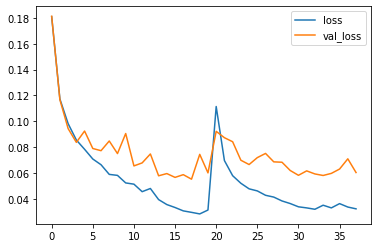

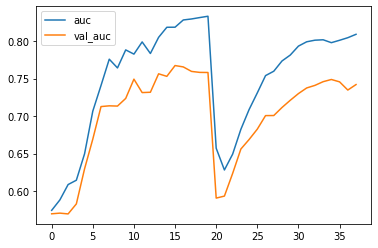

In [138]:
# lstm model 
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
# auc 
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

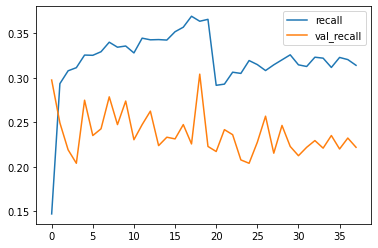

In [139]:
# plot recall rate 
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.legend()
plt.show()

In [21]:
def plot_cm(labels, predictions, p=0.5):
  cm = tf.math.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Positive: ', np.sum(cm[1]))

p = model.predict(data)
plot_cm(targets[:, 1], p[:, 1]) 

In [150]:
# save model if performing better than old model 
# model.save('./model/blind_lstm_v2.h5')

In [141]:
# benchmark - best performing model 
new_model = tf.keras.models.load_model('./model/blind_lstm/blind_lstm.h5')
p = new_model.predict(data)
plot_cm(targets[:, 1], p[:, 1]) 
auc = roc_auc_score(targets[:, 1], p[:, 1])
print(auc) # best peforming mode so far 
plot_cm(targets[:, 1], p[:, 1]) 

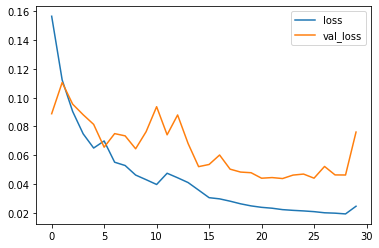

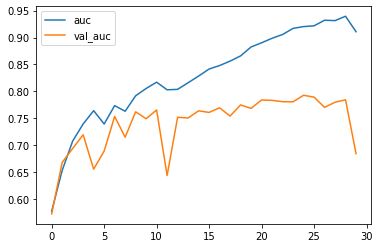

In [166]:
# cnn
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


# plot some data
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

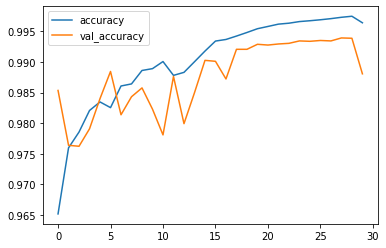

In [169]:
# cnn accuracy - not best metric 
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

True Negatives:  tf.Tensor(237641, shape=(), dtype=int32)
False Positives:  tf.Tensor(1128, shape=(), dtype=int32)
False Negatives:  tf.Tensor(888, shape=(), dtype=int32)
True Positives:  tf.Tensor(1500, shape=(), dtype=int32)
Total Positive:  2388
0.9030369025049497


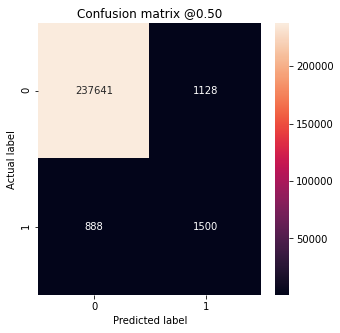

In [168]:
p = model.predict(data)
plot_cm(targets[:, 1], p[:, 1]) 
auc = roc_auc_score(targets[:, 1], p[:, 1])
print(auc) # cnn model 

In [170]:
model.save('./model/blind_cnn.h5')

In [177]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 400)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 400, 100)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 30)          13920     
 l)                                                              
                                                                 
 global_max_pooling1d_10 (Gl  (None, 30)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 2)                 62        
                                                                 
Total params: 2,013,982
Trainable params: 13,982
Non-train

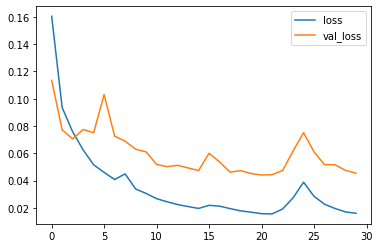

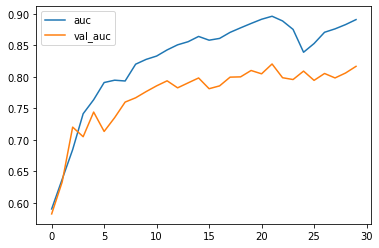

In [178]:
# cnn
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


# plot some data
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

True Negatives:  tf.Tensor(238204, shape=(), dtype=int32)
False Positives:  tf.Tensor(565, shape=(), dtype=int32)
False Negatives:  tf.Tensor(736, shape=(), dtype=int32)
True Positives:  tf.Tensor(1652, shape=(), dtype=int32)
Total Positive:  2388
0.9562931342013997


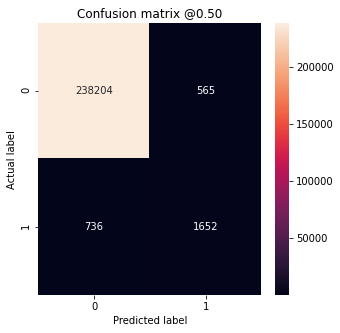

In [179]:
model.save('./model/blind_bidirect_lstm.h5')
p = model.predict(data)
plot_cm(targets[:, 1], p[:, 1]) 
auc = roc_auc_score(targets[:, 1], p[:, 1])
print(auc) # bidirectional lstm model  # best performing model

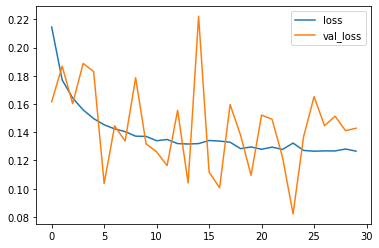

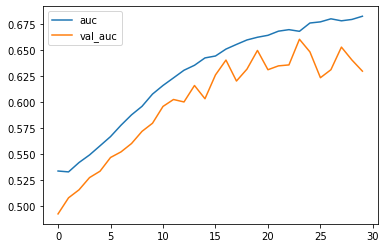

In [19]:
# logit model
# lstm model 
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
# auc 
plt.plot(r.history['auc'], label='auc')
plt.plot(r.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

True Negatives:  tf.Tensor(219081, shape=(), dtype=int32)
False Positives:  tf.Tensor(19688, shape=(), dtype=int32)
False Negatives:  tf.Tensor(917, shape=(), dtype=int32)
True Positives:  tf.Tensor(1471, shape=(), dtype=int32)
Total Positive:  2388
0.8448839378848348


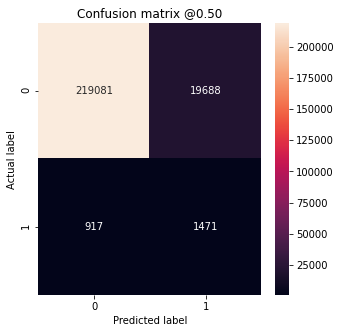

In [23]:
# logit
p = model.predict(data)
plot_cm(targets[:, 1], p[:, 1]) 
auc = roc_auc_score(targets[:, 1], p[:, 1]) # a lot of false positive # not discriminating enough
print(auc) # 0.84

In [24]:
model.save('./model/blind_baseline_logistic.h5')
# bidrectional lstm increase auc from 0.844 to 0.956